In [1]:

### The Plan
# =============================================================================
#
# 1. collect the data
# -- interpolation methods ** just used mean of the week **
# -- scraped price generator website
# 
# 2. visual survey of data to see what kinds of trends might exist
# -- compare to the New Leaf trends that people say exist (big spike, small spike, decreasing, random)
# 
# 3. clustering analysis to determine trend families.
# -- preprocess the data
# ---- explore zero-centering, standard and minmax scaling, up-down indicators
# -- see if the data is separable by stationarity of the time series (could be a good indicator of random trend), 
#     also chi square of up-down
# -- run heirarchical clusters, look at dendrogram to see how many clusters
# -- run kmeans++
# -- visually analyze/compare clustering methods, make sure the clusters make sense
# 
# 4. build classifier
# -- train/test split and scaling
# -- resample if imbalanced
# -- try out softmax ANN and Random Forest
# -- try to get good precision and recall, look at confusion matrix to see if any 
#     particular trend family is hard to get right
# -- see how few days we can use to suitably predict (ideal would be day 1 and purchase price)
#   
# 
# =============================================================================


# Time Series Clustering Analysis of ACNH Turnip Price Trends

## Introduction

In [2]:
import os
import re
import sys
sys.path.append('/Applications/XAMPP/xamppfiles/htdocs/turnip_prices/scripts/python/imports')

import warnings
warnings.filterwarnings('ignore')

import plaidml.keras as pk
pk.install_backend()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.decomposition import PCA

from imblearn.over_sampling import SMOTE, RandomOverSampler

from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import cdist

from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.stattools import adfuller

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils, to_categorical

from db_connection import DBConnect

%matplotlib inline

#### get user data from mysql db

In [3]:
q = """
    SELECT 
        p.*, 
        d.week_id, 
        d.day_of_week,
        case when hour(p.dat) = 0 then 'am' else 'pm' end as time_of_day
    FROM turnip_prices p
    JOIN date_helper_day d ON d.dat = p.dat
"""

with DBConnect(db='turnips') as cnx:
    df_db = pd.read_sql(con=cnx.cnx, sql=q)

In [4]:
df_db.head()

dat  user_id  price  week_id  day_of_week time_of_day
0 2020-03-23 00:00:00        1     44        1            2          am
1 2020-03-23 00:00:00        2     79        1            2          am
2 2020-03-23 12:00:00        1     40        1            2          pm
3 2020-03-23 12:00:00        2     75        1            2          pm
4 2020-03-24 00:00:00        1     36        1            3          am

In [5]:
# pivot data to have days of week in cols, separate weeks in rows
def pivot_data(df):
    
    out = pd.pivot_table(df, index=['week_id', 'user_id'], columns=['day_of_week', 'time_of_day'])
    out.columns = ['Mon-AM', 'Mon-PM', 'Tues-AM', 'Tues-PM', 'Wed-AM', 'Wed-PM', 
                   'Thurs-AM', 'Thurs-PM', 'Fri-AM', 'Fri-PM', 'Sat-AM', 'Sat-PM']
    out.reset_index(drop=True, inplace=True)
    out.dropna(axis=0, inplace=True)
        
    return out

In [6]:
df_db = pivot_data(df_db)
df_db.head()

Mon-AM  Mon-PM  Tues-AM  Tues-PM  Wed-AM  Wed-PM  Thurs-AM  Thurs-PM  \
0    44.0    40.0     36.0     33.0    93.0   124.0     127.0     175.0   
1    79.0    75.0     71.0     68.0    62.0   111.0     108.0     176.0   
5    65.0    61.0     58.0     54.0    49.0   102.0     109.0     159.0   
6   107.0   130.0    153.0    134.0   143.0   117.0      67.0      60.0   
7    60.0   124.0    130.0    145.0   147.0   144.0      75.0      72.0   

   Fri-AM  Fri-PM  Sat-AM  Sat-PM  
0   168.0    54.0    51.0    48.0  
1   189.0   146.0    88.0    83.0  
5   169.0   167.0    58.0    54.0  
6    51.0   100.0    81.0    74.0  
7    67.0    64.0    59.0    55.0

#### get data from csv

In [7]:
def from_csv():
    root = '/Applications/XAMPP/xamppfiles/htdocs/turnip_prices/csv_data/'
    pattern = re.compile(r'turnip-week[1-9]*-gs.csv')
    cols = ['Mon-AM', 'Mon-PM', 'Tues-AM', 'Tues-PM', 'Wed-AM', 'Wed-PM', 
            'Thurs-AM', 'Thurs-PM', 'Fri-AM', 'Fri-PM', 'Sat-AM', 'Sat-PM']
    out = pd.DataFrame(columns=cols)
    
    for f in os.listdir(root):
        if pattern.search(f): 
            dummy = pd.read_csv(root + f).iloc[:, 1:]
            dummy.dropna(inplace=True, axis=0, thresh=8)
            dummy.columns = cols
            out = out.append(dummy)
        else:
            continue
            
    out.reset_index(drop=True, inplace=True)
    
    return out

In [8]:
df_csv = from_csv()
df_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97 entries, 0 to 96
Data columns (total 12 columns):
Mon-AM      91 non-null float64
Mon-PM      91 non-null float64
Tues-AM     95 non-null float64
Tues-PM     96 non-null float64
Wed-AM      95 non-null float64
Wed-PM      91 non-null float64
Thurs-AM    93 non-null float64
Thurs-PM    93 non-null float64
Fri-AM      85 non-null float64
Fri-PM      74 non-null float64
Sat-AM      54 non-null float64
Sat-PM      47 non-null float64
dtypes: float64(12)
memory usage: 9.2 KB


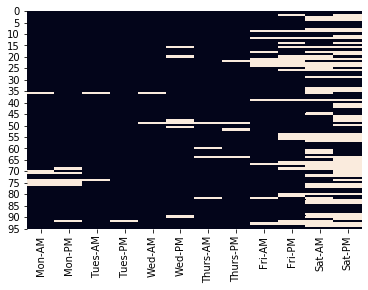

In [9]:
sns.heatmap(df_csv.isnull(), cbar=False)

In [10]:
df_csvT = df_csv.transpose()

for col in list(df_csvT.columns):
    df_csvT.loc[df_csvT[col].isna(), col] = df_csvT[col].mean()

df_csv = df_csvT.transpose()

In [11]:
df_csv.isna().sum()

Mon-AM      0
Mon-PM      0
Tues-AM     0
Tues-PM     0
Wed-AM      0
Wed-PM      0
Thurs-AM    0
Thurs-PM    0
Fri-AM      0
Fri-PM      0
Sat-AM      0
Sat-PM      0
dtype: int64

In [12]:
df_csv.head()

Mon-AM  Mon-PM  Tues-AM  Tues-PM  Wed-AM  Wed-PM  Thurs-AM  Thurs-PM  \
0    96.0    92.0     87.0     83.0    78.0    73.0      68.0      63.0   
1    89.0    86.0     82.0     78.0    74.0    70.0      65.0     122.0   
2   121.0   105.0    110.0     71.0    64.0    54.0      93.0     112.0   
3    99.0    93.0    119.0    202.0   589.0   174.0     105.0      55.0   
4    46.0    43.0     39.0     34.0    30.0    26.0      21.0     126.0   

   Fri-AM  Fri-PM  Sat-AM  Sat-PM  
0    59.0    55.0    50.0    46.0  
1   160.0   342.0   160.0   122.0  
2   123.0    92.4    71.0    92.4  
3    51.0    93.0   158.0   158.0  
4   115.0   204.0    68.4    68.4

#### get generated data

In [13]:
with DBConnect(db='turnips') as cnx:
    df_gen = pd.read_sql(con=cnx.cnx, sql="SELECT * FROM generated_turnip_prices").iloc[:, 1:]
df_gen.head()

Mon-AM  Mon-PM  Tues-AM  Tues-PM  Wed-AM  Wed-PM  Thurs-AM  Thurs-PM  \
0      54      49      126      120     137     139       138        52   
1     108     101      115      152     131      71        61        54   
2      81      77       73       69      65      62        59        56   
3      94      90       87       82     138     213       327       179   
4      58      54       51       47      44      40        36       113   

   Fri-AM  Fri-PM  Sat-AM  Sat-PM  
0      48      44      40      37  
1     153     145      82      75  
2      52      48      44      40  
3     116      73      80      64  
4     103     142     143     142

#### combine the data

In [14]:
df = pd.concat([df_db, df_csv], axis=0)
df = pd.concat([df, df_gen], axis=0)
df = df.sample(frac=1).reset_index(drop=True) # shuffle rows and reset index
df = df.astype(float)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10106 entries, 0 to 10105
Data columns (total 12 columns):
Mon-AM      10106 non-null float64
Mon-PM      10106 non-null float64
Tues-AM     10106 non-null float64
Tues-PM     10106 non-null float64
Wed-AM      10106 non-null float64
Wed-PM      10106 non-null float64
Thurs-AM    10106 non-null float64
Thurs-PM    10106 non-null float64
Fri-AM      10106 non-null float64
Fri-PM      10106 non-null float64
Sat-AM      10106 non-null float64
Sat-PM      10106 non-null float64
dtypes: float64(12)
memory usage: 947.6 KB


In [15]:
def plot_ts(df, title=''):
    df.transpose().plot(legend=False)
    plt.title(title)

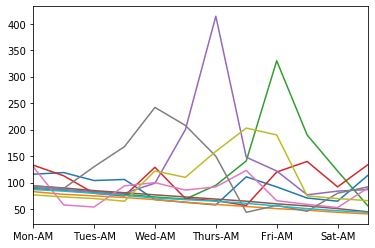

In [16]:
plot_ts(df.head(10))

Check projections for any obvious clustering

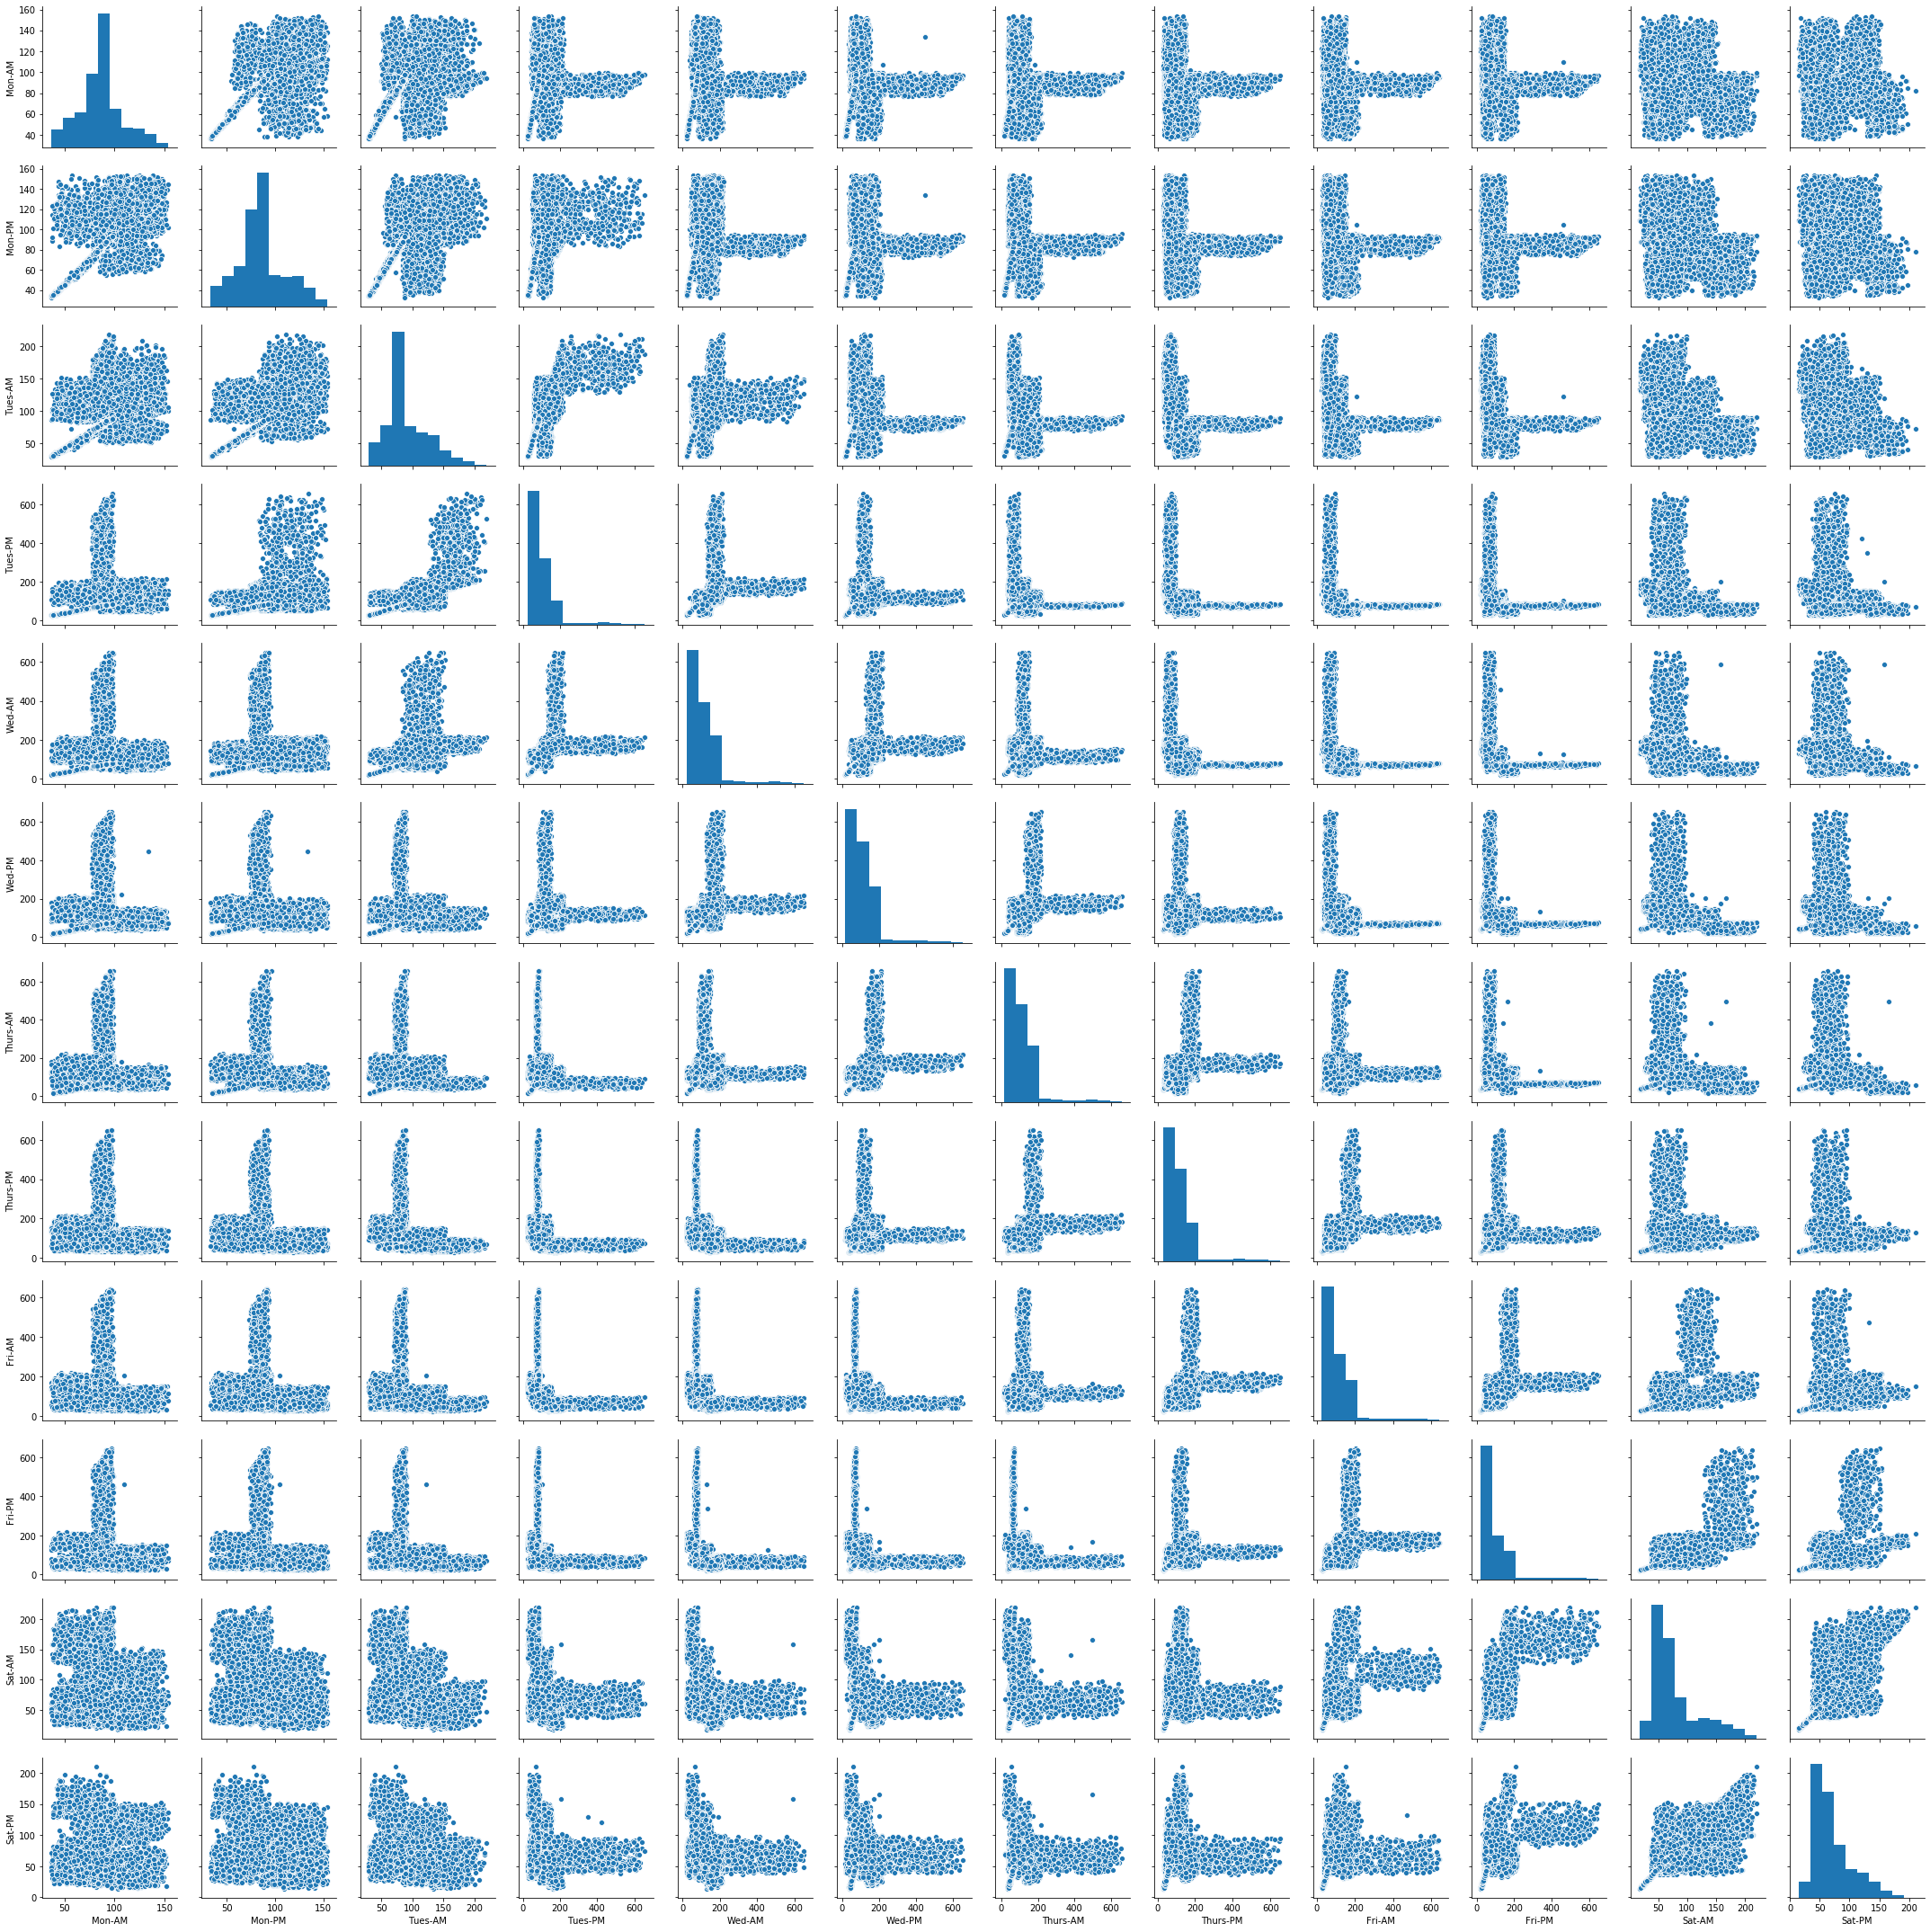

In [17]:
sns.pairplot(df)

## Price Distribution by Day

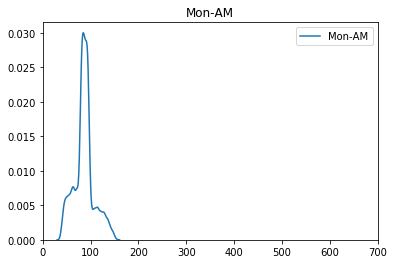

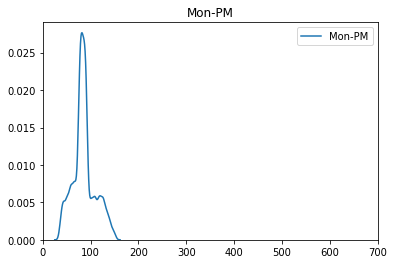

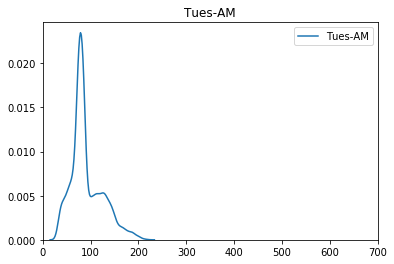

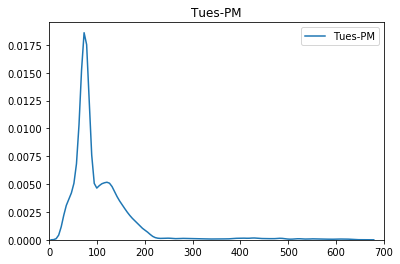

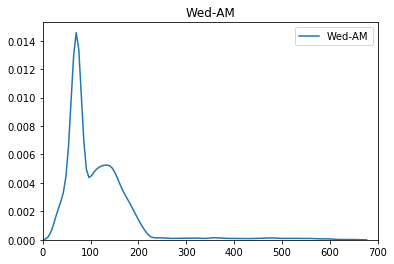

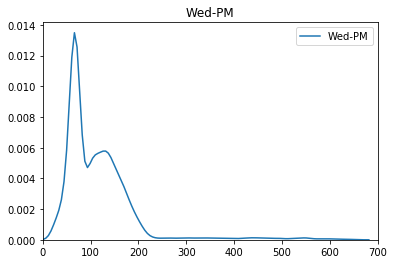

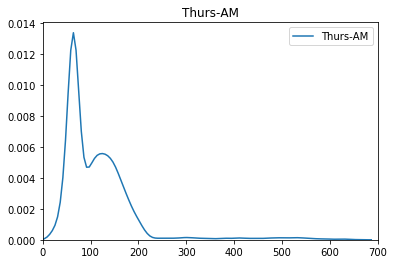

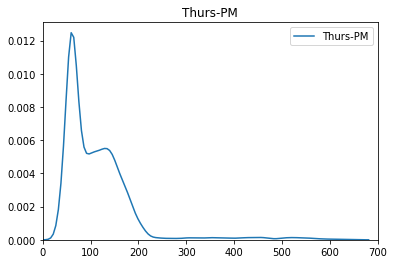

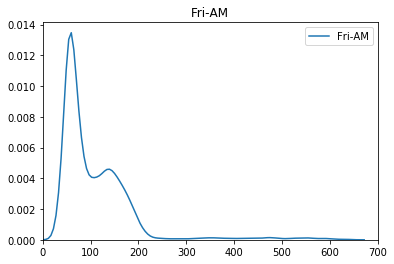

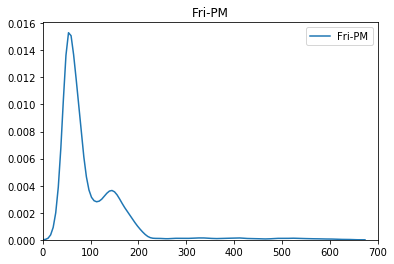

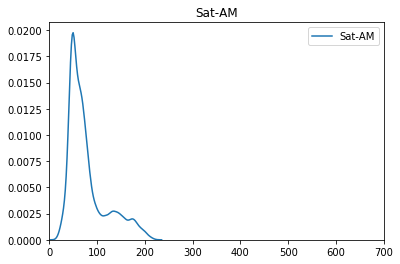

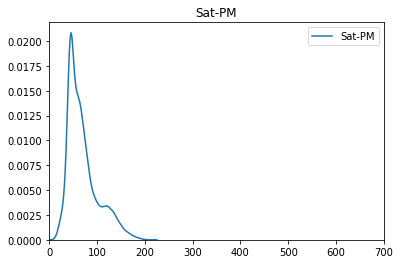

In [18]:
for col in df.columns:
    sns.kdeplot(df[col])
    plt.xlim((0, 700))
    plt.title(col)
    plt.show()

In [19]:
# Prep Data
def scale_data(df):
    
    dfT = df.transpose()
    
    scaler = StandardScaler()
    dfT = scaler.fit_transform(dfT)
    
    df = pd.DataFrame(dfT.transpose())
    #df = pd.DataFrame([x - x[0] for x in df.values], columns=df.columns) # force initial value to zero

    return df

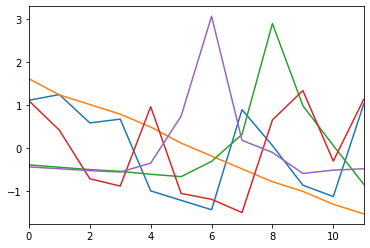

In [20]:
X = scale_data(df)
plot_ts(X.head())

test stationarity

In [21]:
# ADF function -- test for stationarity
def adf_test(series):
    
    #p <= 0.05 means stationary (null hyp is non-stationary)
    result = adfuller(series.dropna(), autolag='AIC')
    
    return result[1] # return p-value

# scan series with window size, search for non-stationary segments
def windowed_stationarity_test(series, window_size):
    
    for i in range(0, len(series)+1-window_size):
        if adf_test(series[i:i+window_size+1]) > 0.05:
            return 'non-stationary'
        
    return 'stationary'

# apply windowed stationarity test to df, add column of results
def add_stationarity_col(df):
    
    stat_vals = []
    for idx, row in df.iterrows():
        stat_vals.append(windowed_stationarity_test(row, 5))
    return stat_vals

In [22]:
#X['stationarity'] = add_stationarity_col(X)

In [23]:
#stationary = X.loc[X['stationarity']=='stationary', :]
#stationary.head()

In [24]:
#plot_ts(stationary.iloc[:5, :-1])

In [25]:
#non_stationary =  X.loc[X['stationarity']!='stationary', :]
#plot_ts(non_stationary.iloc[:5, :-1])

In [26]:
#X.loc[X['stationarity']!='stationary', 'stationarity'] = 1
#X.loc[X['stationarity']=='stationary', 'stationarity'] = 0
#X = X.iloc[:, :-1]

## Hierarchical Clustering

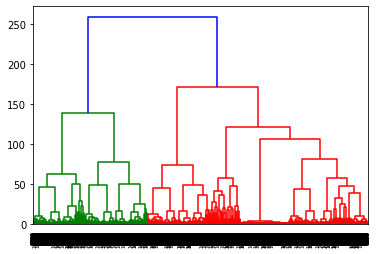

In [27]:
dend = dendrogram(linkage(X, method='ward'))

not much help...

## K-Means ++

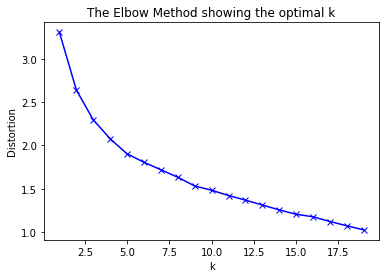

In [28]:
# k means determine k
def elbow_plot(X):
    distortions = []
    K = range(1,20)
    for k in K:
        kmeanModel = KMeans(n_clusters=k,init='k-means++').fit(X)
        distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

    # Plot the elbow
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()
    
elbow_plot(X)

also not much help... just run for k=12, and see how it looks...

In [29]:
n_clusters = 12
clusters = KMeans(n_clusters=n_clusters, init='k-means++').fit_predict(X)

In [30]:
clusters

array([8, 0, 1, ..., 0, 7, 4], dtype=int32)

In [31]:
df['kmeans'] = clusters

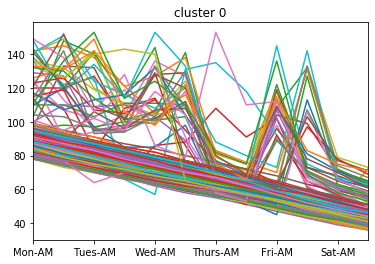

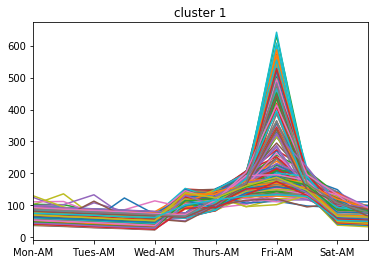

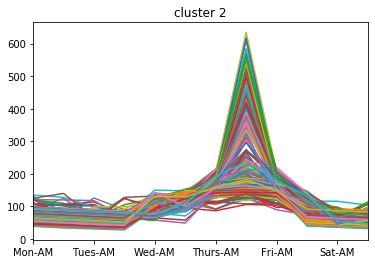

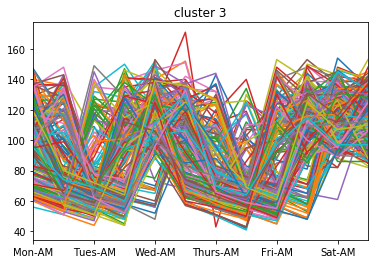

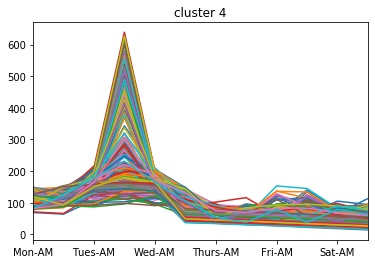

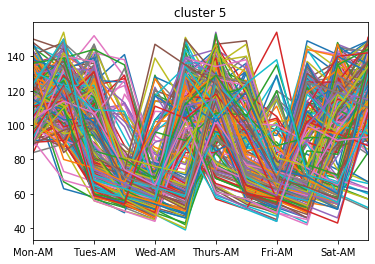

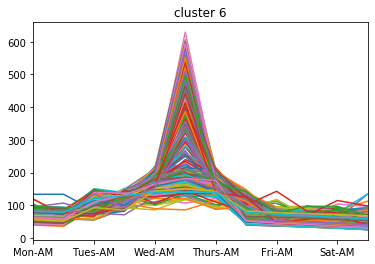

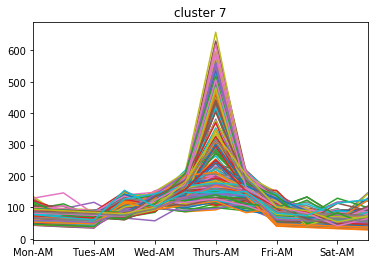

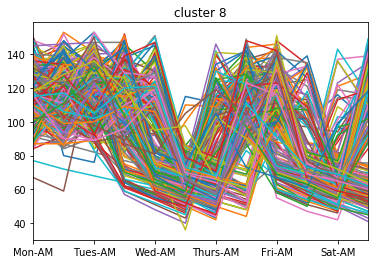

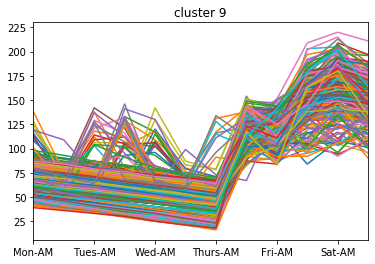

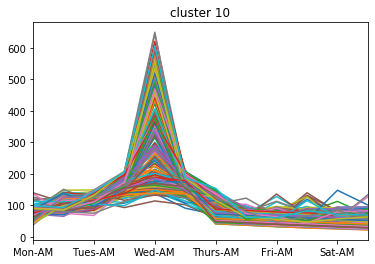

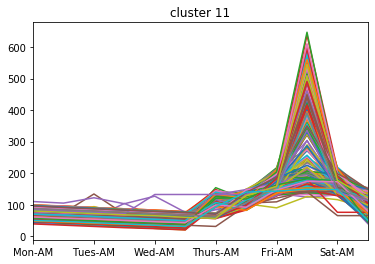

In [32]:
for i in range(0, n_clusters):
    plot_ts(df.loc[df['kmeans']==i].iloc[0:250, :-1], title=f'cluster {i}')

actually not terrible... but could be better...

## DBSCAN

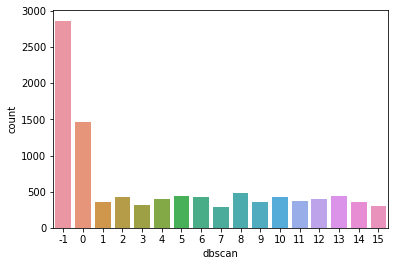

In [33]:
dbscan = DBSCAN(eps=.5, min_samples=18).fit_predict(X)

df['dbscan'] = dbscan
sns.countplot(df['dbscan'])

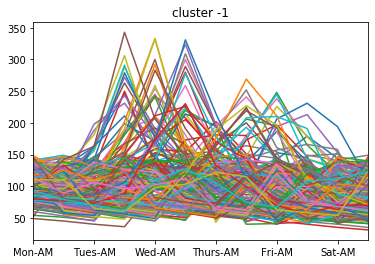

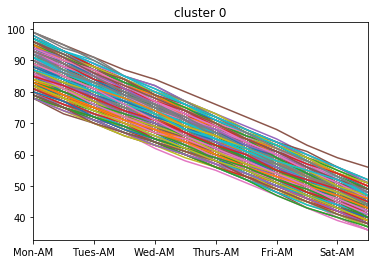

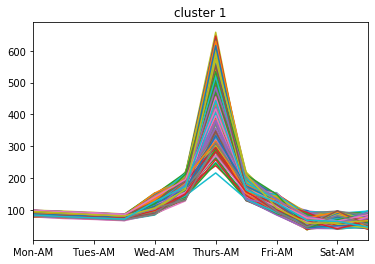

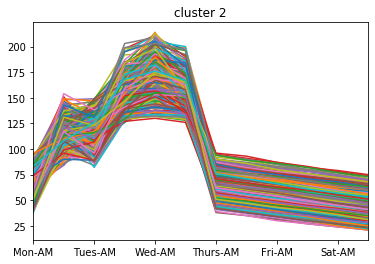

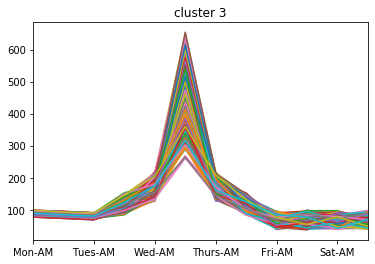

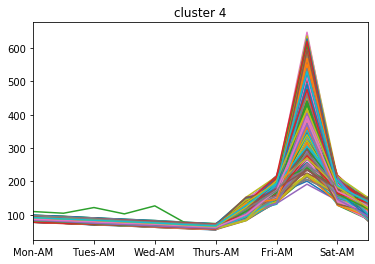

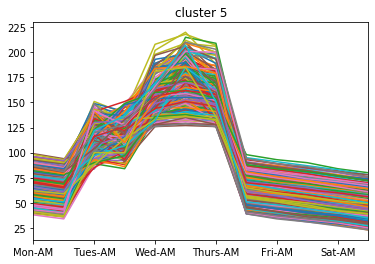

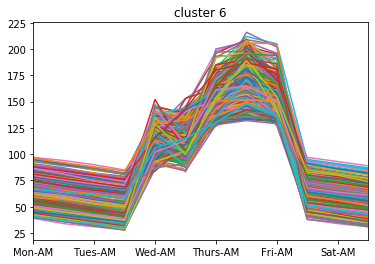

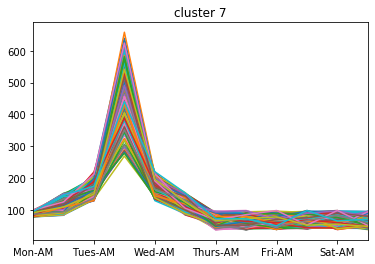

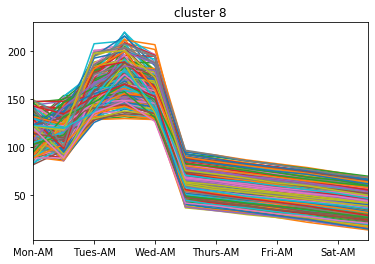

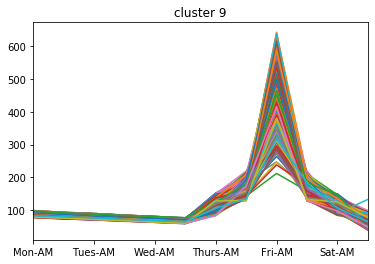

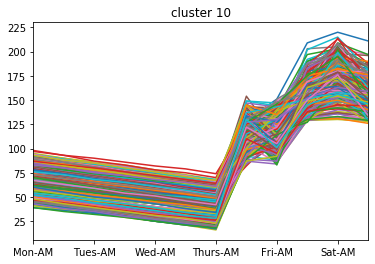

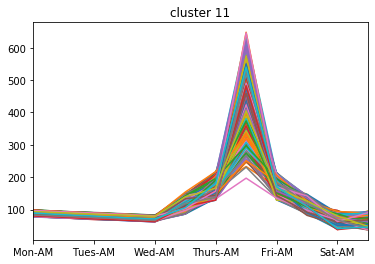

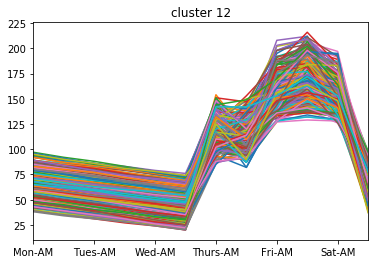

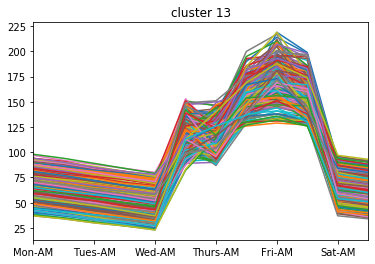

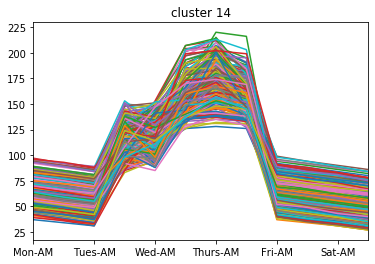

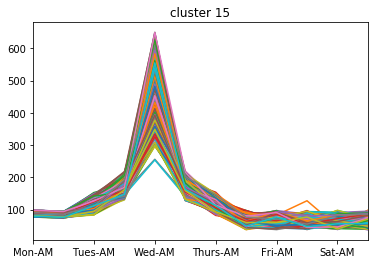

In [34]:
for i in range(-1, dbscan.max()+1):
    plot_ts(df.loc[df['dbscan']==i].iloc[0:250, :-2], title=f'cluster {i}')

this is the one... but the -1 cluster is a bit too big, and I see too many patterns in it. maybe a bigger eps and slightly bigger min_samples? but remember, good results for eps=.5 min_samples=6

# Build Classifier

### resample

In [35]:
col_fltr = df.columns != 'kmeans'
df_cls = df.loc[:, col_fltr]

In [36]:
df_cls

Mon-AM  Mon-PM  Tues-AM  Tues-PM  Wed-AM  Wed-PM  Thurs-AM  Thurs-PM  \
0       116.0   119.0    104.0    106.0    68.0    63.0      58.0     111.0   
1        83.0    78.0     75.0     72.0    68.0    63.0      59.0      55.0   
2        89.0    85.0     81.0     78.0    73.0    69.0      95.0     141.0   
3       133.0   113.0     80.0     75.0   129.0    70.0      66.0      57.0   
4        91.0    87.0     83.0     80.0    99.0   200.0     414.0     148.0   
...       ...     ...      ...      ...     ...     ...       ...       ...   
10101    59.0    55.0    121.0    105.0   152.0   162.0     158.0      74.0   
10102    92.0    88.0     85.0     81.0    77.0    72.0      68.0      97.0   
10103    83.0    78.0     75.0     71.0    67.0    64.0      60.0      56.0   
10104    98.0    93.0     88.0     85.0   104.0   160.0     248.0     215.0   
10105    92.0   105.0    170.0    596.0   171.0   104.0      71.0      58.0   

       Fri-AM  Fri-PM  Sat-AM  Sat-PM  dbscan  
0        92.0    71.0    65.0   114.0      -1  
1        51.0    48.0    44.0    41.0       0  
2       330.0   190.0   122.0    56.0       9  
3       120.0   140.0    92.0   134.0      -1  
4       122.0    77.0    84.0    87.0       1  
...       ...     ...     ...     ...     ...  
10101    70.0    65.0    62.0    58.0       5  
10102   116.0   199.0   202.0   195.0      10  
10103    53.0    49.0    45.0    42.0       0  
10104   111.0    50.0    54.0    96.0      -1  
10105    73.0    47.0    77.0    61.0       7  

[10106 rows x 13 columns]

In [37]:
val_counts = df['dbscan'].value_counts()
max_class = val_counts[val_counts == val_counts.max()].index[0]
class_count = len(val_counts)
print(f'There are {class_count} classes\nThe most frequent class is ({max_class})')

There are 17 classes
The most frequent class is (-1)


In [38]:
cols = df_cls.columns[df_cls.columns != 'dbscan']
X_ann = df_cls.loc[:, cols]
X_ann

Mon-AM  Mon-PM  Tues-AM  Tues-PM  Wed-AM  Wed-PM  Thurs-AM  Thurs-PM  \
0       116.0   119.0    104.0    106.0    68.0    63.0      58.0     111.0   
1        83.0    78.0     75.0     72.0    68.0    63.0      59.0      55.0   
2        89.0    85.0     81.0     78.0    73.0    69.0      95.0     141.0   
3       133.0   113.0     80.0     75.0   129.0    70.0      66.0      57.0   
4        91.0    87.0     83.0     80.0    99.0   200.0     414.0     148.0   
...       ...     ...      ...      ...     ...     ...       ...       ...   
10101    59.0    55.0    121.0    105.0   152.0   162.0     158.0      74.0   
10102    92.0    88.0     85.0     81.0    77.0    72.0      68.0      97.0   
10103    83.0    78.0     75.0     71.0    67.0    64.0      60.0      56.0   
10104    98.0    93.0     88.0     85.0   104.0   160.0     248.0     215.0   
10105    92.0   105.0    170.0    596.0   171.0   104.0      71.0      58.0   

       Fri-AM  Fri-PM  Sat-AM  Sat-PM  
0        92.0    71.0    65.0   114.0  
1        51.0    48.0    44.0    41.0  
2       330.0   190.0   122.0    56.0  
3       120.0   140.0    92.0   134.0  
4       122.0    77.0    84.0    87.0  
...       ...     ...     ...     ...  
10101    70.0    65.0    62.0    58.0  
10102   116.0   199.0   202.0   195.0  
10103    53.0    49.0    45.0    42.0  
10104   111.0    50.0    54.0    96.0  
10105    73.0    47.0    77.0    61.0  

[10106 rows x 12 columns]

In [39]:
y = df_cls['dbscan']
y

0        -1
1         0
2         9
3        -1
4         1
         ..
10101     5
10102    10
10103     0
10104    -1
10105     7
Name: dbscan, Length: 10106, dtype: int64

In [40]:
#smote = SMOTE(ratio='minority')
#X_sm, y_sm = smote.fit_sample(X, y)

In [41]:
ros = RandomOverSampler(ratio='auto', random_state=42);  
X_res, y_res = ros.fit_sample(X_ann, y)

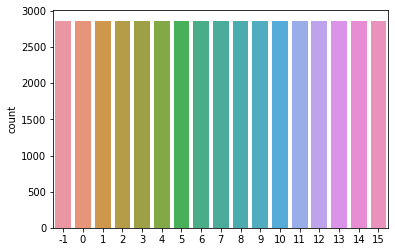

In [42]:
sns.countplot(y_res)

In [43]:
x_train, x_test, y_train, y_test = train_test_split(X_res, y_res, test_size=.4, random_state=100)

In [44]:
feature_count = 6

scaler = MinMaxScaler()
scaler.fit(x_train[:,:feature_count])

x_train = scaler.transform(x_train[:,:feature_count])
x_test = scaler.transform(x_test[:,:feature_count])

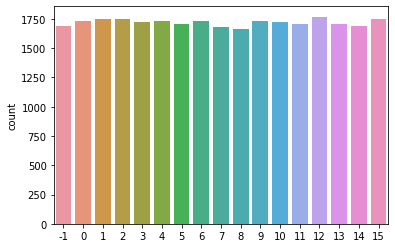

In [45]:
sns.countplot(y_train)

In [46]:
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.fit_transform(y_test)

y_train_cat = to_categorical(y_train_encoded, num_classes=class_count, dtype='float32')
y_test_cat = to_categorical(y_test_encoded, num_classes=class_count, dtype='float32')

### ANN

In [47]:
classifier = Sequential()

classifier.add(Dense(64, input_dim=feature_count))
classifier.add(Activation('relu'))

classifier.add(Dense(128))
classifier.add(Activation('relu'))

classifier.add(Dense(256))
classifier.add(Activation('relu'))

classifier.add(Dense(512))
classifier.add(Activation('relu'))

classifier.add(Dense(1024))
classifier.add(Activation('relu'))

classifier.add(Dense(1024))
classifier.add(Activation('relu'))

classifier.add(Dense(128))
classifier.add(Activation('relu'))

classifier.add(Dense(64))
classifier.add(Activation('relu'))

classifier.add(Dense(class_count))
classifier.add(Activation('softmax'))

classifier.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

INFO:plaidml:Opening device "metal_amd_radeon_pro_570x.0"


In [48]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=10, 
                                            verbose=2, factor=0.5, min_lr=0.00001)

best_model = ModelCheckpoint('trend_classifier_ann.h5', monitor='val_acc', verbose=2, 
                             save_best_only=True, mode='max')

early_stopping = EarlyStopping(monitor='val_loss', min_delta=1e-10, 
                               patience=25,restore_best_weights=True)

model = classifier.fit(x=x_train, y=y_train_cat,
               batch_size=500, epochs=500,
               validation_data=(x_test, y_test_cat),
               callbacks=[learning_rate_reduction,best_model,early_stopping],
               verbose=0)


Epoch 00001: val_acc improved from -inf to 0.74537, saving model to trend_classifier_ann.h5

Epoch 00002: val_acc improved from 0.74537 to 0.74953, saving model to trend_classifier_ann.h5

Epoch 00003: val_acc did not improve from 0.74953

Epoch 00004: val_acc improved from 0.74953 to 0.76516, saving model to trend_classifier_ann.h5

Epoch 00005: val_acc improved from 0.76516 to 0.77532, saving model to trend_classifier_ann.h5

Epoch 00006: val_acc did not improve from 0.77532

Epoch 00007: val_acc did not improve from 0.77532

Epoch 00008: val_acc did not improve from 0.77532

Epoch 00009: val_acc did not improve from 0.77532

Epoch 00010: val_acc improved from 0.77532 to 0.77619, saving model to trend_classifier_ann.h5

Epoch 00011: val_acc improved from 0.77619 to 0.77850, saving model to trend_classifier_ann.h5

Epoch 00012: val_acc improved from 0.77850 to 0.78003, saving model to trend_classifier_ann.h5

Epoch 00013: val_acc improved from 0.78003 to 0.78039, saving model to tren


Epoch 00129: val_acc did not improve from 0.80808

Epoch 00130: val_acc did not improve from 0.80808

Epoch 00131: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 00131: val_acc did not improve from 0.80808

Epoch 00132: val_acc did not improve from 0.80808

Epoch 00133: val_acc did not improve from 0.80808

Epoch 00134: val_acc improved from 0.80808 to 0.80890, saving model to trend_classifier_ann.h5

Epoch 00135: val_acc did not improve from 0.80890

Epoch 00136: val_acc improved from 0.80890 to 0.80972, saving model to trend_classifier_ann.h5

Epoch 00137: val_acc did not improve from 0.80972

Epoch 00138: val_acc did not improve from 0.80972

Epoch 00139: val_acc did not improve from 0.80972

Epoch 00140: val_acc did not improve from 0.80972

Epoch 00141: val_acc did not improve from 0.80972

Epoch 00142: val_acc did not improve from 0.80972

Epoch 00143: val_acc did not improve from 0.80972

Epoch 00144: val_acc did not improve from 0.80972

Epoch 00145:


Epoch 00283: val_acc did not improve from 0.81080

Epoch 00284: val_acc did not improve from 0.81080

Epoch 00285: val_acc did not improve from 0.81080

Epoch 00286: val_acc did not improve from 0.81080

Epoch 00287: val_acc did not improve from 0.81080

Epoch 00288: val_acc did not improve from 0.81080

Epoch 00289: val_acc did not improve from 0.81080

Epoch 00290: val_acc did not improve from 0.81080

Epoch 00291: val_acc did not improve from 0.81080

Epoch 00292: val_acc did not improve from 0.81080

Epoch 00293: val_acc did not improve from 0.81080

Epoch 00294: val_acc did not improve from 0.81080

Epoch 00295: val_acc did not improve from 0.81080

Epoch 00296: val_acc did not improve from 0.81080

Epoch 00297: val_acc did not improve from 0.81080

Epoch 00298: val_acc did not improve from 0.81080

Epoch 00299: val_acc did not improve from 0.81080

Epoch 00300: val_acc did not improve from 0.81080

Epoch 00301: val_acc did not improve from 0.81080

Epoch 00302: val_acc did not i

This ANN is getting just above 81% accuracy on the test set when using 3 days of data (6 price observations), which isn't too terrible, but it leaves a relatively high chance that one misses the highest price while still waiting for there to be enough data for the classifier to work.

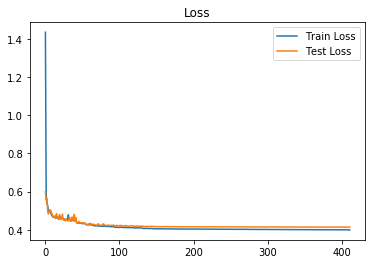

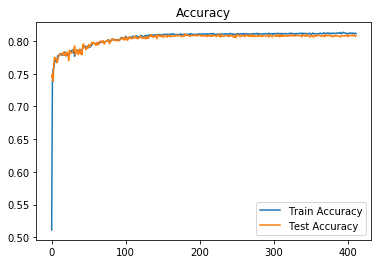

In [49]:
plt.title('Loss')
plt.plot(model.history['loss'], label='Train Loss')
plt.plot(model.history['val_loss'], label='Test Loss')
plt.legend()
plt.show()

plt.title('Accuracy')
plt.plot(model.history['acc'], label='Train Accuracy')
plt.plot(model.history['val_acc'], label='Test Accuracy')
plt.legend()
plt.show()

### Random Forest

In [50]:
rf = RandomForestClassifier()

In [51]:
n_estimators = [x for x in range(1,201,10)]
max_features = ['auto', 'sqrt']
max_depth = [x for x in range(1, 101, 10)] + [None]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

params = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap   
}

rf_grid = RandomizedSearchCV(estimator = rf, param_distributions = params,
                             n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

In [52]:
rf_grid.fit(x_train, y_train_cat)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   42.9s
[Parallel(n_jobs=-1)]: Done 150 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  7.1min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None

In [53]:
rf_grid.best_params_

{'n_estimators': 51,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 91,
 'bootstrap': True}

In [54]:
best_rf = rf_grid.best_estimator_

preds = best_rf.predict(x_test)
acc = accuracy_score(preds, y_test_cat)
print(f'Accuracy: {round(acc*100,2)}%')

Accuracy: 94.28%


In [55]:
kfold = KFold(n_splits=10, shuffle=True)
kfold_results = cross_val_score(best_rf, x_test, y_test_cat, cv=kfold)

In [56]:
results = f'KFold Avg. Accuracy: {round(kfold_results.mean()*100, 2)}% ({round(kfold_results.std()*100,2)})%'
print(results)

KFold Avg. Accuracy: 92.51% (0.37)%


In [57]:
decoded_preds = le.inverse_transform(preds.argmax(axis=1))
decoded_cats = le.inverse_transform(y_test_cat.argmax(axis=1))

report = classification_report(decoded_cats, decoded_preds)
print(report)

              precision    recall  f1-score   support

          -1       0.83      0.82      0.83      1176
           0       0.87      0.63      0.73      1133
           1       0.98      1.00      0.99      1122
           2       0.99      1.00      0.99      1121
           3       0.98      1.00      0.99      1142
           4       0.80      0.83      0.81      1134
           5       0.99      1.00      0.99      1161
           6       0.99      1.00      0.99      1136
           7       0.99      1.00      1.00      1184
           8       1.00      1.00      1.00      1206
           9       0.81      0.88      0.84      1135
          10       0.93      0.94      0.93      1145
          11       0.98      1.00      0.99      1159
          12       0.94      0.93      0.94      1099
          13       0.99      1.00      0.99      1158
          14       0.98      1.00      0.99      1176
          15       0.99      1.00      1.00      1116

    accuracy              

In [58]:
def labeled_cm(actuals, preds, normalize=False, precision=2):
    """Create a labeled confusion matrix.
    
    Args:
        actuals (nx1 numpy.array): Actual label values from data.
        preds (nx1 numpy.array): Predicted label values from model.
        
    Returns:
        cm (pandas.DataFrame): Labeled confusion matrix.
    """
    
    if len(actuals) != len(preds):
        raise ValueError('Arguments must have the same length.')
        
    labels = list(set([x for x in actuals]))
    labels.sort()
    
    confusion_dict = {}
    for l in labels:
        confusion_dict[str(l)] = {}
        for k in labels:
            confusion_dict[str(l)][str(k)] = 0
            
    for i in range(len(actuals)):
        confusion_dict[str(actuals[i])][str(preds[i])] += 1
        
    cm = pd.DataFrame()
    
    for i in labels:
        i = str(i)
        for j in confusion_dict[i].keys():
            cm.loc[i, j] = confusion_dict[i][j]
            
    if normalize:
        for l in labels:
            cm.loc[str(l), :] = round(cm.loc[str(l), :] / cm.loc[str(l), :].sum(), precision)
        
    return cm

In [59]:
cm = labeled_cm(decoded_cats, decoded_preds, normalize=True)
cm

-1     0     1     2     3     4     5     6     7    8     9    10  \
-1  0.82  0.02  0.02  0.01  0.02  0.01  0.01  0.01  0.01  0.0  0.01  0.00   
0   0.09  0.63  0.00  0.00  0.00  0.14  0.00  0.00  0.00  0.0  0.11  0.02   
1   0.00  0.00  1.00  0.00  0.00  0.00  0.00  0.00  0.00  0.0  0.00  0.00   
2   0.00  0.00  0.00  1.00  0.00  0.00  0.00  0.00  0.00  0.0  0.00  0.00   
3   0.00  0.00  0.00  0.00  1.00  0.00  0.00  0.00  0.00  0.0  0.00  0.00   
4   0.04  0.04  0.00  0.00  0.00  0.83  0.00  0.00  0.00  0.0  0.06  0.03   
5   0.00  0.00  0.00  0.00  0.00  0.00  1.00  0.00  0.00  0.0  0.00  0.00   
6   0.00  0.00  0.00  0.00  0.00  0.00  0.00  1.00  0.00  0.0  0.00  0.00   
7   0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  1.00  0.0  0.00  0.00   
8   0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  1.0  0.00  0.00   
9   0.03  0.03  0.00  0.00  0.00  0.04  0.00  0.00  0.00  0.0  0.88  0.01   
10  0.01  0.00  0.00  0.00  0.00  0.01  0.00  0.00  0.00  0.0  0.02  0.94   
11  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.0  0.00  0.00   
12  0.01  0.01  0.00  0.00  0.00  0.01  0.00  0.00  0.00  0.0  0.02  0.01   
13  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.0  0.00  0.00   
14  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.0  0.00  0.00   
15  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.0  0.00  0.00   

      11    12    13    14    15  
-1  0.02  0.00  0.01  0.03  0.01  
0   0.00  0.01  0.00  0.00  0.00  
1   0.00  0.00  0.00  0.00  0.00  
2   0.00  0.00  0.00  0.00  0.00  
3   0.00  0.00  0.00  0.00  0.00  
4   0.00  0.01  0.00  0.00  0.00  
5   0.00  0.00  0.00  0.00  0.00  
6   0.00  0.00  0.00  0.00  0.00  
7   0.00  0.00  0.00  0.00  0.00  
8   0.00  0.00  0.00  0.00  0.00  
9   0.00  0.00  0.00  0.00  0.00  
10  0.00  0.03  0.00  0.00  0.00  
11  1.00  0.00  0.00  0.00  0.00  
12  0.00  0.93  0.00  0.00  0.00  
13  0.00  0.00  1.00  0.00  0.00  
14  0.00  0.00  0.00  1.00  0.00  
15  0.00  0.00  0.00  0.00  1.00

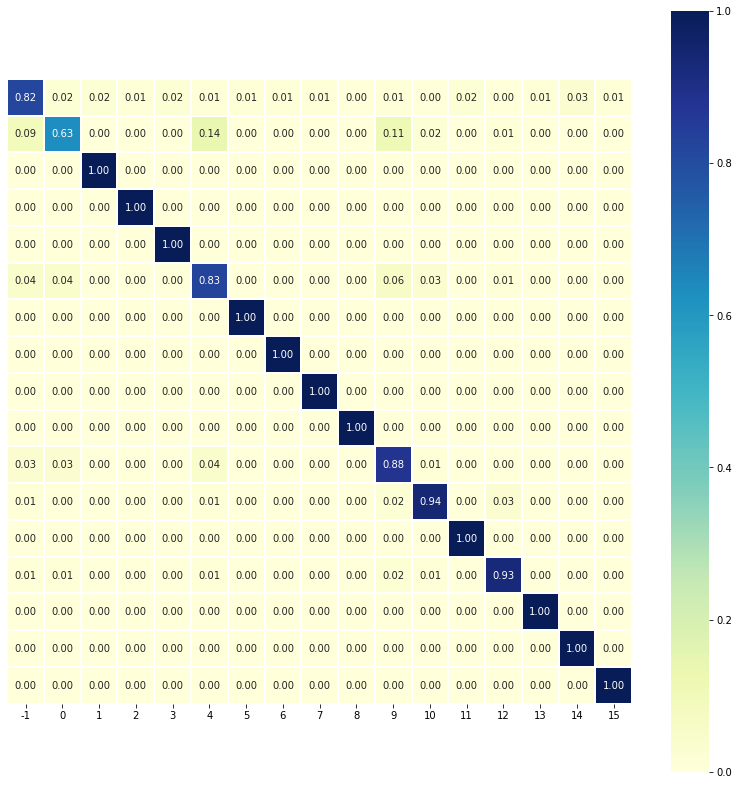

In [60]:
plt.figure(figsize=(14,14))
sns.heatmap(cm, annot=True, fmt = '.2f', square=1, linewidth=1., yticklabels=False, cmap='YlGnBu')